In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from src.models import CrossEntropyClassification
from src.data import train_val_test_split, get_descriptor_and_labels
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, RichProgressBar
import torch
import numpy as np

# Reproducing results from [Connection between liquid and non-crystalline solid phases in water](https://doi.org/10.1063/5.0018923)

Here we train our NN on HDA, LDA and high-T liquid as done in the work by Martelli et al.
These results are shown in Section 2.1 of the SI.

In [4]:
train_structs, val_structs, test_structs = train_val_test_split(struct_types=['lda','hda','liquid'],mda=False)

In [5]:
len(train_structs), len(val_structs), len(test_structs)

(1523, 29, 1372)

In [6]:
numb_train_samples = 16_000
train_x, train_y, label_mapping = get_descriptor_and_labels(train_structs,num_samples_per_type=numb_train_samples)
val_x, val_y, _ = get_descriptor_and_labels(val_structs, num_samples_per_type=2_500)

In [10]:
from sklearn import preprocessing

# standardize the data
scaler = preprocessing.StandardScaler().fit(train_x)
scaled_train_x = torch.FloatTensor(scaler.transform(train_x))
scaled_val_x = torch.FloatTensor(scaler.transform(val_x))

In [11]:
train_dataset = TensorDataset(scaled_train_x,train_y)
val_dataset = TensorDataset(scaled_val_x,val_y)

train_loader = DataLoader(train_dataset, batch_size=400, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10000, shuffle=False)

### Define the NN

We optimised parameters of our NN in in [NN_optimisation.ipynb](NN_optimisation.ipynb).
Here we load in those results and define our network architecture before training.

In [12]:
import optuna
study_name = "optimise_NN"  # Unique identifier of the study.
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)

optimised_NN_params = study.best_params
n_layers, neurons_per_layer, weight_decay, lr = optimised_NN_params.values()


[I 2023-12-17 12:20:48,297] Using an existing study with name 'optimise_NN' instead of creating a new one.


In [13]:
# define the neural network architecture
input_size = scaled_train_x.shape[1] # number of features; 30 in this case
output_size = train_y.shape[1] # number of output labels; 3 in this case (HDA, LDA, high-T liquid)

hidden_layers = [neurons_per_layer] * n_layers

torch.manual_seed(42)
neural_net = CrossEntropyClassification(
    input_size,
    *hidden_layers,
    output_size,
    learning_rate=lr,
    weight_decay=weight_decay,
)

In [14]:
trainer = Trainer(
        accelerator="auto",
        max_epochs=200,
        callbacks=[
            RichProgressBar(),
            EarlyStopping(monitor="validation_loss", patience=10),
        ],
    )
trainer.fit(neural_net, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ activation │ ReLU       │      0 │
│ 1 │ layers     │ ModuleList │ 16.4 K │
└───┴────────────┴────────────┴────────┘

Trainable params: 16.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 16.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

/Users/zoefaurebeaulieu/miniconda3/envs/steinhardt/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may 
be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus 
on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/Users/zoefaurebeaulieu/miniconda3/envs/steinhardt/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which 
may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of 
cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

### Test the model

In [15]:
from src.data import predict_test_set_classes
from sklearn.metrics import balanced_accuracy_score

pred_classes, test_classes, confidences = predict_test_set_classes(test_structs,model=neural_net, scaler=scaler)

av_accuracy = balanced_accuracy_score(test_classes, pred_classes)
print(f"Balanced accuracy (%): {av_accuracy*100:.1f}")

Balanced accuracy (%): 94.0


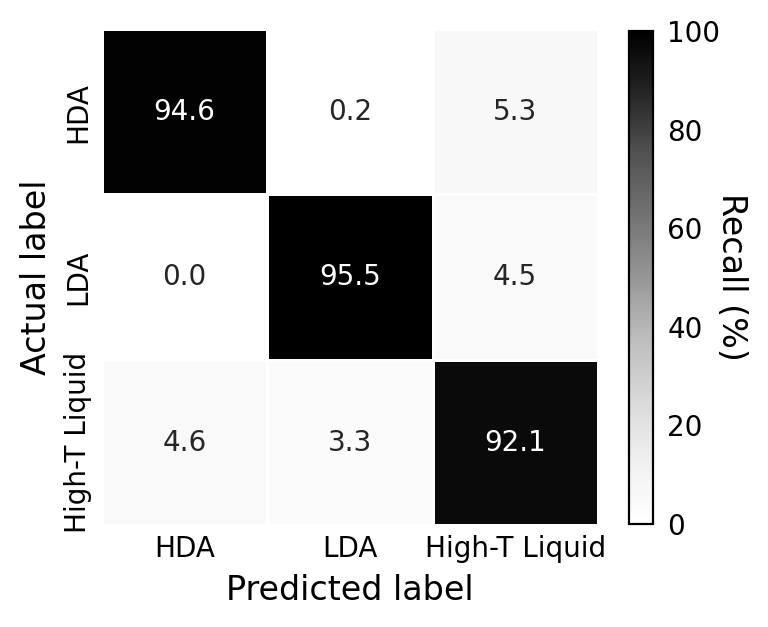

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.style.use('default')

fig, ax = plt.subplots(figsize=(4,4))

cm = confusion_matrix(test_classes, pred_classes, normalize='true')
sns.heatmap(cm*100, annot=True, ax=ax, cmap='Greys', fmt='.1f',linewidths=0.5,square=True,cbar=False)

plot_labels = ['HDA','LDA', 'High-T Liquid']
ax.set_xticks([0.5, 1.5, 2.5],plot_labels)
ax.set_yticks([0.5, 1.5, 2.5],plot_labels)

# remove spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
ax.set_ylabel('Actual label',fontsize=12);
ax.set_xlabel('Predicted label',fontsize=12);
ax.tick_params(length=0)
    
# add a colorbar
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=100)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greys)
cmap.set_array([])
cbar = fig.colorbar(cmap, ax=ax,shrink=0.8)
cbar.set_label('Recall (%)', rotation=270, labelpad=10,fontsize=12)
# change the cbar tick length
cbar.ax.tick_params(length=0,pad=5)

plt.savefig(f'../figures/cm_withLiquid.svg',dpi=300,bbox_inches='tight')

In [17]:
from src.data import get_kde
# calculate the KDEs for each class
x_values = np.linspace(40,110,400)
kdes = []
for i in range(0,len(plot_labels)):
    kde = get_kde(confidences[test_classes==i]*100,x_values,normalise=True)
    kdes.append(kde)

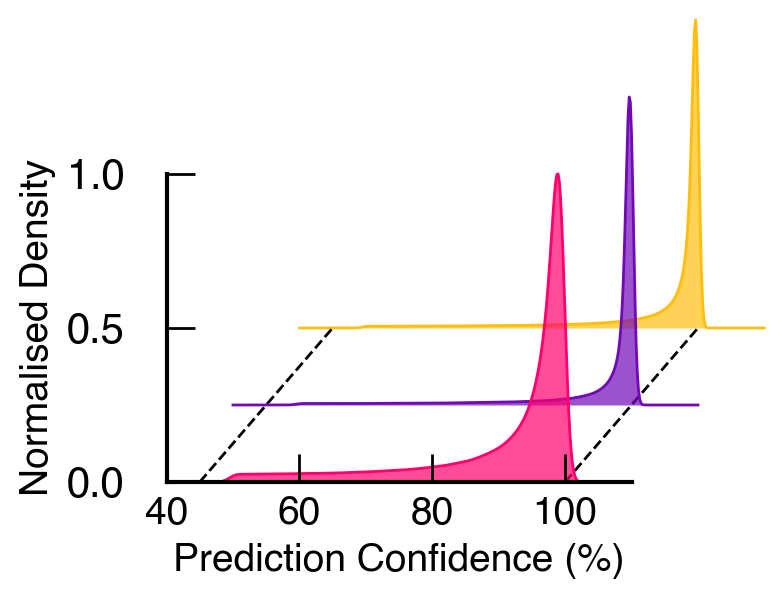

In [18]:
plt.style.use('plot.mplstyle')
fig, ax = plt.subplots(figsize=(3,2))

labels = ['HDA','LDA','High-T Liquid']
colors = ['#ffbe0b','#7209b7','#ff006e']

for i in range(0,len(labels)):
    dx, dy = -i*10, -i*0.25 + 0.5
    ax.plot(x_values + dx, kdes[i] + dy, label=labels[i], color=colors[i], zorder=i,linewidth=1,clip_on=False)
    ax.fill_between(x_values + dx, kdes[i] + dy, dy, color=colors[i], zorder=i, label=labels[i],alpha=0.7,linewidth=0,clip_on=False)
    
ax.plot([80,100],[0,0.5],color='black',linestyle='dashed',linewidth=1,zorder=0,clip_on=False)
ax.plot([25,45],[0,0.5],color='black',linestyle='dashed',linewidth=1,zorder=0,clip_on=False)

# remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks([20,40,60,80])
ax.set_xticklabels([40,60,80,100],fontsize=14)

#reduce space between x-axis and labels
ax.tick_params(axis='x', which='major', pad=5)

# have x ticks in front of plot
ax.set_axisbelow(False)

ax.set_ylim(0,1)
ax.set_xlim(20,90)

# plt.legend(fontsize=12,loc='upper left')
ax.set_xlabel('Prediction Confidence (%)',fontsize=14);
ax.set_ylabel('Normalised Density',fontsize=14);